In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from eda import *
from feature_selection import *
from model_train import *
from preprocess import *
from semi_supervised import *
from postprocessing import plot_result, classif_weld, count_fail_cause


%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)        # Afficher toutes les lignes
pd.set_option('display.max_columns', None)     # Afficher toutes les colonnes

# Preprocessing

In [3]:
df_origin = pd.read_csv("data/welddb.data", delim_whitespace=True,header=None)
df_origin.head(2)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.037,0.3,0.65,0.008,0.012,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,170,21,DC,+,1.0,200,MMA,250,14,392,466,31.9,80.6,N,N,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.3,0.65,0.008,0.012,0,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,170,21,DC,+,1.0,200,MMA,0,0,N,N,N,N,-28,100,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aawch


### Handling Missing Values

After loading the dataset and performing an initial inspection, we notice that some entries are represented as `"N"`

To properly handle these missing values in our analysis, we convert all `"N"` entries to `NaN`

In [4]:
df=df_origin.copy()

In [5]:
df=replace_N_with_NaN(df)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.037,0.3,0.65,0.008,0.012,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,21,DC,+,1.0,200,MMA,250,14,392,466,31.9,80.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.3,0.65,0.008,0.012,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,21,DC,+,1.0,200,MMA,0,0,NaN,NaN,NaN,NaN,-28,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch


### Renaming Columns and Dropping Irrelevant Features

Another issue we notice is that the dataset lacks meaningful column names; they are currently represented by numbers.  
To simplify our analysis, we assign descriptive names to each column using the `identify_columns` function.  

Additionally, we drop the `"Weld ID"` column, as it is an identifier and does not provide useful information for modeling.

In [6]:
df=identify_columns(df)

### Basic Dataset Overview

We start by examining the **basic figures of the dataset**:

- **Dimensions:** Number of rows (observations) and columns (features)
- **Global distributions:** Basic statistics for numeric columns (mean, std, min, max, etc.)
- **Missing values:** Number and percentage of `NaN` entries per column

This gives us a quick understanding of the structure, completeness, and types of the data before preprocessing

In [7]:
data_analysis_2(df,basic_info=True)

### Dataset Overview
- Number of observations: 1652
- Number of features: 43


,Column,Non-Null Count,Missing %,Dtype
50% FATT,50% FATT,31.00,98.12,object
Tungsten concentration,Tungsten concentration,75.00,95.46,object
Ferrite with carbide aggregate,Ferrite with carbide aggregate,89.00,94.61,object
Martensite,Martensite,89.00,94.61,object
Acicular ferrite,Acicular ferrite,90.00,94.55,object
Ferrite with second phase,Ferrite with second phase,90.00,94.55,object
Primary ferrite in microstructure,Primary ferrite in microstructure,98.00,94.07,object
Cobalt concentration,Cobalt concentration,129.00,92.19,object
Hardness,Hardness,138.00,91.65,object
Arsenic concentration,Arsenic concentration,234.00,85.84,object



### Descriptive Statistics


,Carbon concentration,Silicon concentration,Manganese concentration,Heat input
count,1652.00,1652.00,1652.00,1652.00
mean,0.08,0.33,1.20,1.70
std,0.02,0.11,0.38,1.30
min,0.03,0.04,0.27,0.60
25%,0.06,0.27,0.94,1.00
50%,0.07,0.32,1.27,1.00
75%,0.09,0.36,1.44,2.00
max,0.18,1.14,2.25,7.90



 End of report


- The **rate of missing values (`NaN`)** varies widely across columns.  
  We will decide how to handle them depending on how high the missing rate is.
  
- There is also a **data type issue**: many columns are stored as `object` instead of numeric,  
  which explains why the default `.describe()` only summarizes a few columns.  

We will need to **convert these columns to the correct types** before any statistical analysis or modeling.


In [8]:
display(pd.DataFrame(df.dtypes[:6],columns=['dtype']))

,dtype
Carbon concentration,float64
Silicon concentration,float64
Manganese concentration,float64
Sulphur concentration,object
Phosphorus concentration,object
Nickel concentration,object


### Investigating Column Types

Many columns are currently of type `object`, which explains why some statistics are missing in `.describe()`.  

- **Categorical columns:** represent categories or labels  
- **Numeric columns stored as strings:** should be converted to numeric types for analysis  
- **Mixed or irregular entries:** e.g., ranges or special characters  

Below are some examples showing the issues in different columns:

In [9]:
df.iloc[1024,7]


'<0.01'

In [10]:
df['AC or DC'].value_counts()

AC or DC
DC    1395
AC      42
Name: count, dtype: int64

In [11]:
df.iloc[1024,14]

'95'

### Handling Inequalities and String Issues

To clean the dataset, we create **two functions** to handle:

1. **Inequalities** in numeric columns (values starting with `<`)  
2. **Strings or irregular entries** in columns that should be numeric  

We will test different strategies later to decide how to replace these inequality values.

**Strategies for handling `<x` values:**

- `"half"`   : replace `<x` with `x / 2`  
- `"minus10"`: replace `<x` with `x - 10%` (i.e., `x * 0.9`)  
- `"zero"`   : replace `<x` with `0`  

This approach allows us to **standardize numeric values** and make the dataset ready for analysis and modeling.

In [12]:
df=convert_numeric_columns(df, skip_indices=None, extract_indices=None, ineq_strategy="half")

### Correlation Analysis

Next, we examine the **correlation matrix** to understand relationships between numeric features:

- Identify which features are **highly correlated** 
- This analysis helps us **decide which features to keep or combine**


### Correlation Matrix


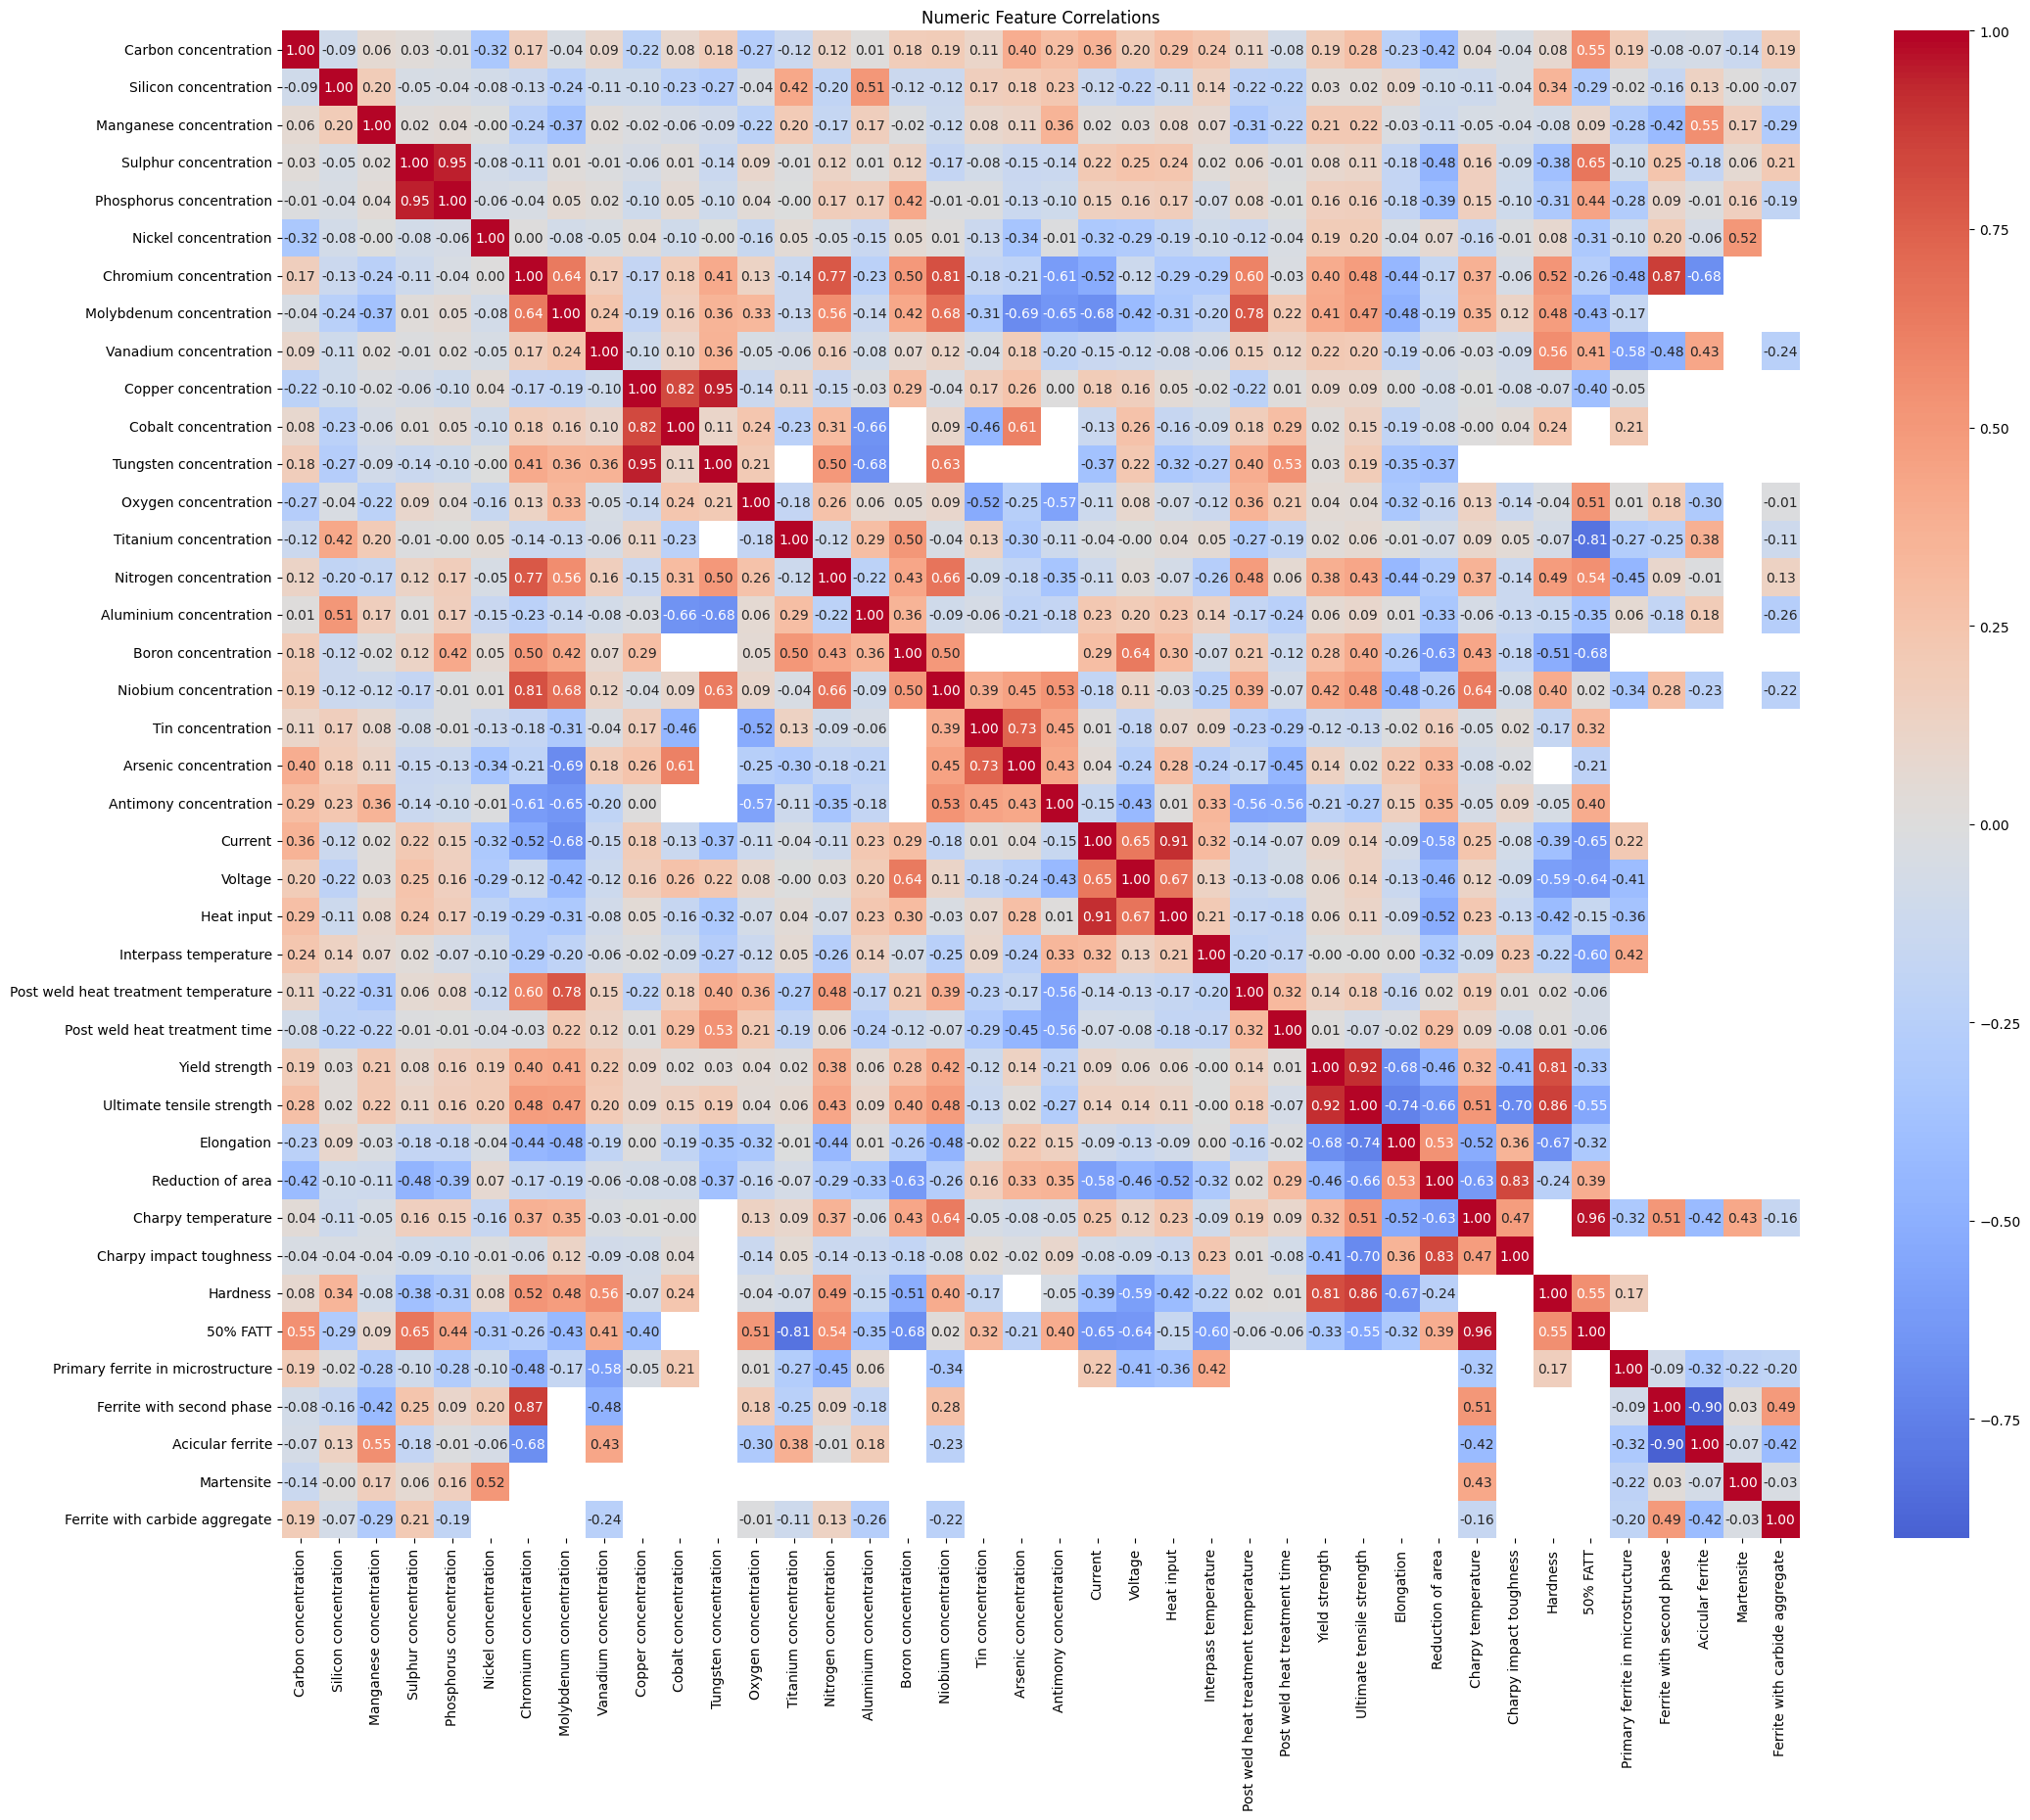


### Highly Correlated Feature Pairs (|corr| > 0.8)


,Feature 1,Feature 2,Correlation
637,Charpy temperature,50% FATT,0.96
114,Sulphur concentration,Phosphorus concentration,0.95
308,Copper concentration,Tungsten concentration,0.95
614,Yield strength,Ultimate tensile strength,0.92
548,Current,Heat input,0.91
649,Ferrite with second phase,Acicular ferrite,0.90
247,Chromium concentration,Ferrite with second phase,0.87
625,Ultimate tensile strength,Hardness,0.86
633,Reduction of area,Charpy impact toughness,0.83
307,Copper concentration,Cobalt concentration,0.82



 End of report


In [13]:
data_analysis_2(df,correlation_matrix=True,high_correlation=True)

### Analysis of correlation matrix

- There is a strong correlation between **Yield Strength**, **Ultimate Tensile Strength**, and another related feature.  
  - Cause or correlation is unclear.  
  - For simplicity, we will **select only one of these features** as the target for quality criteria.  

- **Charpy Impact Toughness** is strongly linked to **Reduction of Area**.  
  - To simplify the analysis, we will **keep only Reduction of Area** as the target variable.  

- Other correlated features that are **not targets** will **not be removed**.  
  - A **forward feature selection** will be performed later.  
  - The selection process is expected to pick only one of the highly correlated features.


### Definition of the target cols

In [14]:
target_cols = ['Yield strength', 'Ultimate tensile strength', 'Elongation',
       'Reduction of area']

In [15]:
df.loc[:5,target_cols]

,Yield strength,Ultimate tensile strength,Elongation,Reduction of area
0,392.0,466.0,31.9,80.6
1,NaN,NaN,NaN,NaN
2,370.0,456.0,35.2,80.6
3,413.0,498.0,31.2,80.6
4,NaN,NaN,NaN,NaN
5,402.0,490.0,31.0,80.6


### Target NaN

In [16]:
data_analysis_2(df[target_cols],
                  missingness=True)


### Missing Values Table


,unique_values,missing_rate
Elongation,135.00,57.63
Reduction of area,122.00,57.32
Ultimate tensile strength,306.00,55.33
Yield strength,329.00,52.78



 End of report


- All target variables have a **high rate of missing values**.  
- This will require the use of **semi-supervised techniques** to handle the missing data effectively.

### On the Treatment of NaN for the features

- According to the thesis:  
  - Missing values for **Phosphorus** and **Sulfur** should be replaced with their **mean values**.  
  - For **all other concentration values**, missing data indicates the element is not present and should be set to **0**.  

- For **non-concentration features**, missing values will be handled using an **Iterative Imputer** with a **mean strategy**.


### Numeric Feature Distributions


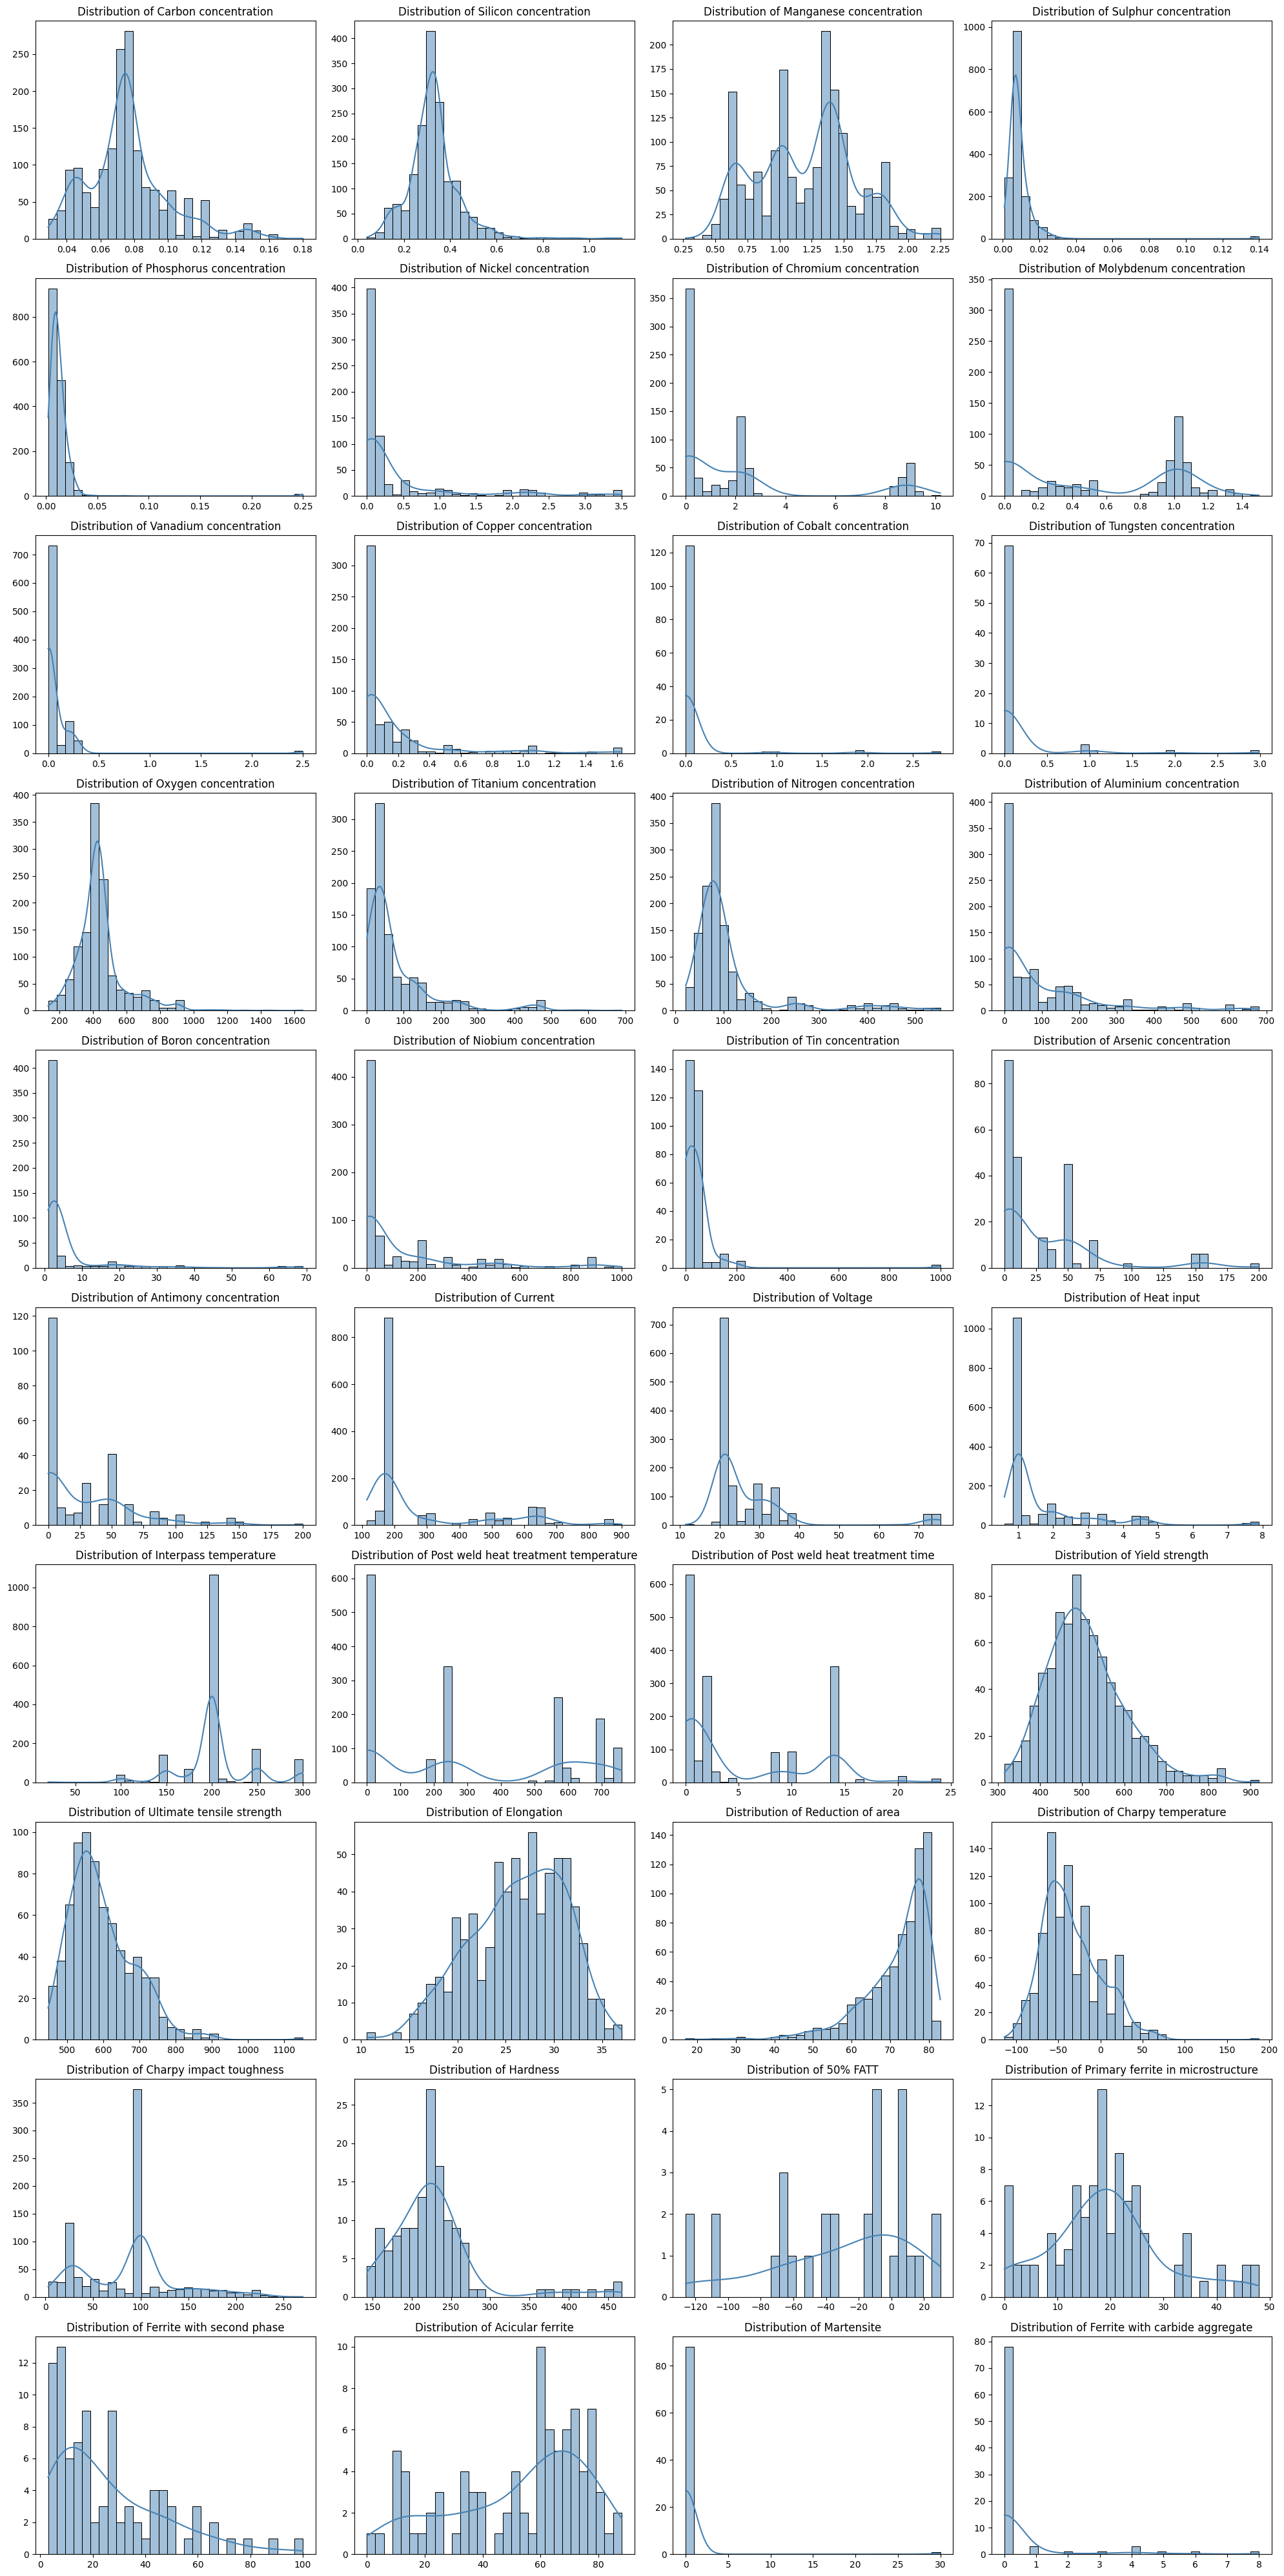


### Categorical Feature Distributions (Top 20 values)


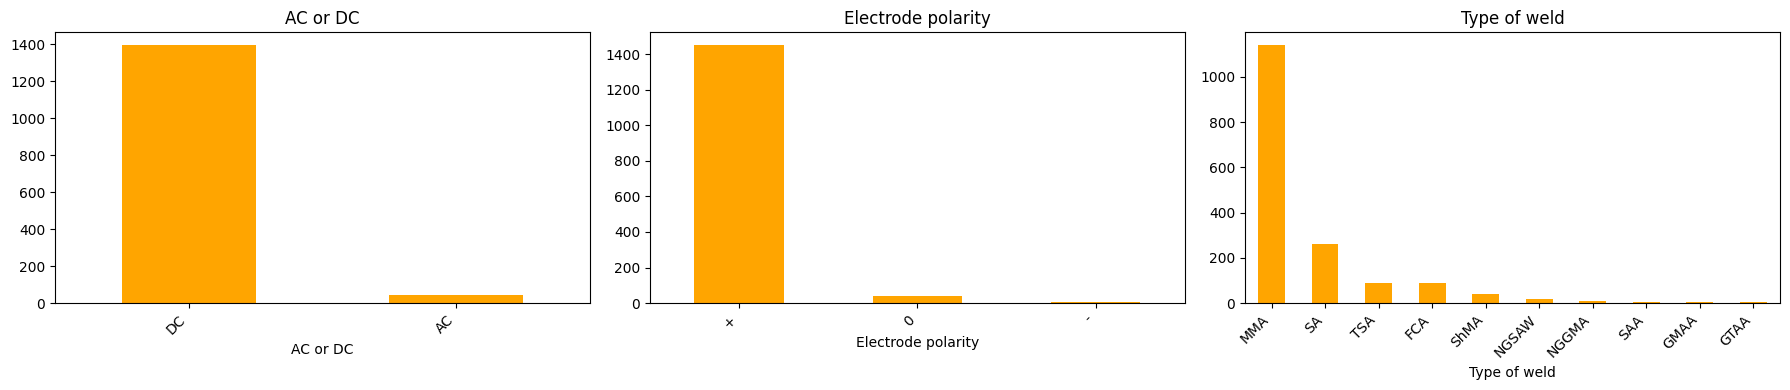


 End of report


In [17]:
data_analysis_2(df,categorical_distrib=True,feature_distrib=True)

### One-Hot Encoding Categorical Features

To prepare the data for modeling, we **one-hot encode all categorical columns**:

- Each category becomes a separate binary column (0 or 1)  
- Missing values are treated as a separate category (e.g., `"Unknown"`)  
- This ensures that **all features are numeric**

In [18]:
df=encode_features(df)
df.head()

,Carbon concentration,Silicon concentration,Manganese concentration,Sulphur concentration,Phosphorus concentration,Nickel concentration,Chromium concentration,Molybdenum concentration,Vanadium concentration,Copper concentration,Cobalt concentration,Tungsten concentration,Oxygen concentration,Titanium concentration,Nitrogen concentration,Aluminium concentration,Boron concentration,Niobium concentration,Tin concentration,Arsenic concentration,Antimony concentration,Current,Voltage,Heat input,Interpass temperature,Post weld heat treatment temperature,Post weld heat treatment time,Yield strength,Ultimate tensile strength,Elongation,Reduction of area,Charpy temperature,Charpy impact toughness,Hardness,50% FATT,Primary ferrite in microstructure,Ferrite with second phase,Acicular ferrite,Martensite,Ferrite with carbide aggregate,AC or DC_AC,AC or DC_DC,AC or DC_Unknown,Electrode polarity_+,Electrode polarity_-,Electrode polarity_0,Electrode polarity_Unknown,Type of weld_FCA,Type of weld_GMAA,Type of weld_GTAA,Type of weld_MMA,Type of weld_NGGMA,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,21.0,1.0,200.0,250.0,14.0,392.0,466.0,31.9,80.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,21.0,1.0,200.0,0.0,0.0,NaN,NaN,NaN,NaN,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,21.0,1.0,200.0,580.0,2.0,370.0,456.0,35.2,80.6,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,21.0,1.0,200.0,250.0,14.0,413.0,498.0,31.2,80.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.0,21.0,1.0,200.0,0.0,0.0,NaN,NaN,NaN,NaN,-48.0,100.0,NaN,NaN,32.0,28.0,40.0,0.0,0.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


# Training models

### Defining Features for the Model

- **Numerical features:** Columns with continuous or discrete numerical values that the model can directly use.
- **One-hot encoded features:** Categorical columns transformed into binary columns (0/1) to represent each category.

These two lists define the full set of features that will be passed to the models and feed forward feature selection

In [19]:
numerical_cols = ['Carbon concentration', 'Silicon concentration', 'Manganese concentration', 'Sulphur concentration', 
                  'Phosphorus concentration', 'Nickel concentration', 'Chromium concentration', 'Molybdenum concentration', 
                  'Vanadium concentration', 'Copper concentration', 'Cobalt concentration', 'Tungsten concentration', 
                  'Oxygen concentration', 'Titanium concentration', 'Nitrogen concentration', 'Aluminium concentration', 
                  'Boron concentration', 'Niobium concentration', 'Tin concentration', 'Arsenic concentration', 'Antimony concentration', 
                  'Current', 'Voltage', 'Heat input']

onehot_cols = ['AC or DC_AC', 'AC or DC_DC', 'AC or DC_Unknown', 'Electrode polarity_+', 'Electrode polarity_-', 
               'Electrode polarity_0', 'Electrode polarity_Unknown', 'Type of weld_FCA', 'Type of weld_GMAA', 
               'Type of weld_GTAA', 'Type of weld_MMA', 'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA', 
               'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']


### First Model Trials – Brute Force Approach

- We initially train several models in a “brute force” manner to quickly test different algorithms and settings
- The goal is to evaluate performance on all targets and identify the most promising approach
- For simplicity, we focus on **'Yield strength'** as the main target to compare models
- This step allows us to benchmark algorithms before performing more refined feature selection and hyperparameter tuning

In [20]:
target_name = 'Yield strength'

# Definition several regression models
regressors_to_test = [
    # XGBoost
    (XGBRegressor, [
        dict(objective='reg:squarederror', random_state=42, n_estimators=200, learning_rate=0.05, max_depth=3, subsample=0.6, colsample_bytree=0.9, n_jobs=-1),
        dict(objective='reg:squarederror', random_state=42, n_estimators=500, learning_rate=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.8, n_jobs=-1),
    ]),
    # Random Forest
    (RandomForestRegressor, [
        dict(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1),
        dict(n_estimators=300, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1),
    ]),
    # Gradient Boosting
    (GradientBoostingRegressor, [
        dict(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
        dict(n_estimators=500, learning_rate=0.1, max_depth=4, random_state=42),
    ]),
    # Ridge Regression
    (Ridge, [
        dict(alpha=1.0, random_state=42),
        dict(alpha=10.0, random_state=42),
    ]),
    # Lasso Regression
    (Lasso, [
        dict(alpha=0.1, random_state=42),
        dict(alpha=1.0, random_state=42),
    ]),
    # Support Vector Regressor
    (SVR, [
        dict(kernel='rbf', C=1.0, epsilon=0.1),
        dict(kernel='linear', C=1.0, epsilon=0.1),
    ]),
]

results = []

# Loop on all the models to test each algo
for regressor_class, param_list in regressors_to_test:
    for params in param_list:
        rmse, corr, rapport = train_regressor_target(
            df=df,
            target_name=target_name,
            numerical_cols=numerical_cols,
            onehot_cols=onehot_cols,
            regressor=regressor_class,
            params=params,
            n_splits=10,
            plot=False
        )
        results.append({
            "model": regressor_class.__name__,
            "params": params,
            "rmse": rmse,
            "corr": corr,
            "rmse_div_mean_%": rapport
        })

# Rank algo by RMSE
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by="rmse").reset_index(drop=True)
display(df_results_sorted)


,model,params,rmse,corr,rmse_div_mean_%
0,XGBRegressor,"{'objective': 'reg:squarederror', 'random_stat...",43.546858,0.885657,8.56
1,GradientBoostingRegressor,"{'n_estimators': 500, 'learning_rate': 0.1, 'm...",44.405577,0.880026,8.73
2,GradientBoostingRegressor,"{'n_estimators': 200, 'learning_rate': 0.05, '...",44.555799,0.880427,8.76
3,XGBRegressor,"{'objective': 'reg:squarederror', 'random_stat...",45.244499,0.874594,8.90
4,RandomForestRegressor,"{'n_estimators': 100, 'max_depth': None, 'min_...",46.115329,0.868048,9.07
5,RandomForestRegressor,"{'n_estimators': 300, 'max_depth': 10, 'min_sa...",46.798395,0.864621,9.20
6,Lasso,"{'alpha': 1.0, 'random_state': 42}",66.921875,0.693122,13.16
7,Lasso,"{'alpha': 0.1, 'random_state': 42}",67.082170,0.695236,13.19
8,Ridge,"{'alpha': 10.0, 'random_state': 42}",67.164231,0.693224,13.21
9,Ridge,"{'alpha': 1.0, 'random_state': 42}",67.209728,0.694762,13.22


In [21]:
display(df_results_sorted['params'][0])

{'objective': 'reg:squarederror',
 'random_state': 42,
 'n_estimators': 200,
 'learning_rate': 0.05,
 'max_depth': 3,
 'subsample': 0.6,
 'colsample_bytree': 0.9,
 'n_jobs': -1}

### Model Selection and Feature Considerations

- After testing multiple algorithms, the **best performing model** appears to be an **XGBoost Regressor**.  
  We'll adopt this model for the subsequent steps.

- Up to now, models have been trained using **all available features**.  
  To improve generalization and reduce computational complexity, we want to **select only the most relevant features**

- **Reasons for feature selection:**
  - Reduce the risk of **overfitting**
  - Mitigate the **curse of dimensionality**

In [22]:
best_features={}
for target in target_cols:
    print(f'{target}')
    best_features[target]=fast_forward_selection_manual_cv(df, numerical_cols, onehot_cols, target,
                                     regressor=XGBRegressor,
                                     params={'objective': 'reg:squarederror',
                                                'random_state': 42,
                                                'n_estimators': 200,
                                                'learning_rate': 0.05,
                                                'max_depth': 3,
                                                'subsample': 0.6,
                                                'colsample_bytree': 0.9,
                                                'n_jobs': -1},
                                     max_features=15,
                                     n_splits=5)
    

Yield strength
Step  1 | Added: Molybdenum concentration       | RMSE=76.51 (15.0%)
Step  2 | Added: Manganese concentration        | RMSE=69.98 (13.8%)
Step  3 | Added: Chromium concentration         | RMSE=60.19 (11.8%)
Step  4 | Added: Nickel concentration           | RMSE=55.60 (10.9%)
Step  5 | Added: Niobium concentration          | RMSE=50.80 (10.0%)
Step  6 | Added: Vanadium concentration         | RMSE=48.32 (9.5%)
Step  7 | Added: Silicon concentration          | RMSE=46.28 (9.1%)
Step  8 | Added: Phosphorus concentration       | RMSE=44.64 (8.8%)
Step  9 | Added: Titanium concentration         | RMSE=44.56 (8.8%)
Step 10 | Added: Oxygen concentration           | RMSE=43.61 (8.6%)
Step 11 | Added: Current                        | RMSE=43.31 (8.5%)
Step 12 | Added: Copper concentration           | RMSE=42.70 (8.4%)
Step 13 | Added: Carbon concentration           | RMSE=42.79 (8.4%)
Step 14 | Added: Tin concentration              | RMSE=42.38 (8.3%)
Step 15 | Added: Cobalt conc

Selected features are displayed here

In [23]:
for target in target_cols:
    print(f'{target} : \n {best_features[target]}')

Yield strength : 
 ['Molybdenum concentration', 'Manganese concentration', 'Chromium concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Phosphorus concentration', 'Titanium concentration', 'Oxygen concentration', 'Current', 'Copper concentration', 'Carbon concentration', 'Tin concentration', 'Cobalt concentration']
Ultimate tensile strength : 
 ['Chromium concentration', 'Manganese concentration', 'Molybdenum concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Voltage', 'Carbon concentration', 'Copper concentration', 'Oxygen concentration', 'Titanium concentration', 'AC or DC_AC', 'Aluminium concentration', 'Type of weld_SA']
Elongation : 
 ['Chromium concentration', 'Niobium concentration', 'Titanium concentration', 'Carbon concentration', 'Nickel concentration', 'Manganese concentration', 'Aluminium concentration', 'Type of weld_MMA', 'Molybdenum concentr

In [24]:
# Historical selected features
best_features={}

best_features['Yield strength'] = ['Molybdenum concentration', 'Manganese concentration', 'Chromium concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Phosphorus concentration', 'Titanium concentration', 'Oxygen concentration', 'Current', 'Copper concentration', 'Carbon concentration', 'Tin concentration', 'Cobalt concentration']
best_features['Ultimate tensile strength'] = ['Chromium concentration', 'Manganese concentration', 'Molybdenum concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Voltage', 'Carbon concentration', 'Copper concentration', 'Oxygen concentration', 'Titanium concentration', 'AC or DC_AC', 'Aluminium concentration', 'Type of weld_SA']
best_features['Elongation'] = ['Chromium concentration', 'Niobium concentration', 'Titanium concentration', 'Carbon concentration', 'Nickel concentration', 'Manganese concentration', 'Aluminium concentration', 'Type of weld_MMA', 'Molybdenum concentration', 'Arsenic concentration', 'Vanadium concentration', 'Antimony concentration', 'Sulphur concentration', 'AC or DC_Unknown', 'Electrode polarity_0']
best_features['Reduction of area'] = ['Voltage', 'Molybdenum concentration', 'Oxygen concentration', 'Chromium concentration', 'Nickel concentration', 'Antimony concentration', 'Boron concentration', 'Arsenic concentration', 'Niobium concentration', 'Manganese concentration', 'Aluminium concentration', 'Nitrogen concentration', 'Heat input', 'Tin concentration', 'Type of weld_SA']


### Comparing Model Performance on all targets

- **Objective:** Evaluate how feature selection impacts model performance.  

- **Setup:**
  - Train an **XGBoost Regressor** on **all features**.
  - Train the same model using only the **15 best features** identified via **forward selection**.

- **Metrics to compare:**
  - RMSE (Root Mean Squared Error)
  - Relative RMSE (% of mean target value)
  - Correlation between predicted and true values

- **Purpose:** Check whether reducing the number of features maintains predictive accuracy while simplifying the model

In [25]:
# XGBoost parameters used for comparison
xgb_params = dict(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.9,
    n_jobs=-1
)

In [26]:
results_all = []

for target in target_cols:
    # All features score
    rmse_full, corr_full, rmse_pct_full = train_regressor_target(
        df=df,
        target_name=target,
        numerical_cols=numerical_cols,
        onehot_cols=onehot_cols,
        plot=False,
        regressor=XGBRegressor,
        params=xgb_params,
        n_splits=10
    )

    # 15 best features score
    numerical_cols_reduced = get_numerical_cols(best_features[target])
    onehot_cols_reduced = get_onehot_cols(best_features[target])

    rmse_reduced, corr_reduced, rmse_pct_reduced = train_regressor_target(
        df=df,
        target_name=target,
        numerical_cols=numerical_cols_reduced,
        onehot_cols=onehot_cols_reduced,
        plot=False,
        regressor=XGBRegressor,
        params=xgb_params,
        n_splits=10
    )

    # Stock results for comparison
    results_all.append({
        "Target": target,
        "RMSE_all_features": rmse_full,
        "RMSE%_all_features": rmse_pct_full,
        "Corr_all_features": corr_full,
        "RMSE_15_best": rmse_reduced,
        "RMSE%_15_best": rmse_pct_reduced,
        "Corr_15_best": corr_reduced
    })

# Convert to df and display result
df_results = pd.DataFrame(results_all)
df_results = df_results.sort_values(by="RMSE_15_best", ascending=False)
pd.set_option("display.float_format", "{:.2f}".format)
display(df_results)

,Target,RMSE_all_features,RMSE%_all_features,Corr_all_features,RMSE_15_best,RMSE%_15_best,Corr_15_best
0,Yield strength,43.30,8.51,0.88,42.37,8.33,0.89
1,Ultimate tensile strength,33.71,5.67,0.92,34.05,5.73,0.92
3,Reduction of area,4.71,6.56,0.85,4.77,6.64,0.85
2,Elongation,2.76,10.49,0.83,2.78,10.59,0.83


- **Observation:** The results remain similar in terms of performance,  
  but by keeping only the **essential features**, we reduce the risk of **overfitting**

### Selection of the Inequalities Strategy

- For these initial results, we **randomly decided** to handle inequality values (those starting with `<`) by replacing them with **half of the given number**.
- Other strategies are possible, such as:
  - Replacing `<x` with `x / 2`
  - Replacing `<x` with `x * 0.9` (10% less)
  - Replacing `<x` with `0`
  - Replacing `<x` with `x`  
- Next, we will **compare these strategies** to determine which one gives the **best performance** after imputation.

In [27]:
ineq_strategies = ["half", "minus10", "zero", "no change"]

xgb_params = dict(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.6,
    colsample_bytree=0.9,
    n_jobs=-1
)

df_results = benchmark_ineq_strategies(df_origin, target_cols, best_features, xgb_params, ineq_strategies)

# Display per target and corr
display(df_results.sort_values(["target", "corr"], ascending=[True, False]))


,target,ineq_strategy,corr,rmse,rmse_rel
0,Elongation,minus10,0.83,2.75,10.46
1,Elongation,no change,0.83,2.76,10.49
2,Elongation,half,0.83,2.78,10.59
3,Elongation,zero,0.82,2.82,10.74
4,Reduction of area,half,0.85,4.77,6.64
5,Reduction of area,minus10,0.85,4.77,6.64
6,Reduction of area,zero,0.85,4.78,6.65
7,Reduction of area,no change,0.84,4.80,6.69
8,Ultimate tensile strength,zero,0.92,33.85,5.69
9,Ultimate tensile strength,half,0.92,34.05,5.73


- Based on the results, we **selected the "minus 10%" strategy** for handling inequalities.  
- This strategy provides the **best scores for "Elongation"** and **"Yield strength"**, while still maintaining **good performance** for **"Ultimate Tensile Strength"** and **"Reduction of area"**.

## Final training and inference

### Semi-supervised learning

We optimized our model parameters and imputation strategies to achieve the best possible scores.

After reloading the full dataset, we now proceed with **semi-supervised learning** to handle the NaN in the target

In [28]:
target_cols = ['Yield strength', 'Ultimate tensile strength', 'Elongation',
       'Reduction of area']

# Historical selected features
best_features={}

best_features['Yield strength'] = ['Molybdenum concentration', 'Manganese concentration', 'Chromium concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Phosphorus concentration', 'Titanium concentration', 'Oxygen concentration', 'Current', 'Copper concentration', 'Carbon concentration', 'Tin concentration', 'Cobalt concentration']
best_features['Ultimate tensile strength'] = ['Chromium concentration', 'Manganese concentration', 'Molybdenum concentration', 'Nickel concentration', 'Niobium concentration', 'Vanadium concentration', 'Silicon concentration', 'Voltage', 'Carbon concentration', 'Copper concentration', 'Oxygen concentration', 'Titanium concentration', 'AC or DC_AC', 'Aluminium concentration', 'Type of weld_SA']
best_features['Elongation'] = ['Chromium concentration', 'Niobium concentration', 'Titanium concentration', 'Carbon concentration', 'Nickel concentration', 'Manganese concentration', 'Aluminium concentration', 'Type of weld_MMA', 'Molybdenum concentration', 'Arsenic concentration', 'Vanadium concentration', 'Antimony concentration', 'Sulphur concentration', 'AC or DC_Unknown', 'Electrode polarity_0']
best_features['Reduction of area'] = ['Voltage', 'Molybdenum concentration', 'Oxygen concentration', 'Chromium concentration', 'Nickel concentration', 'Antimony concentration', 'Boron concentration', 'Arsenic concentration', 'Niobium concentration', 'Manganese concentration', 'Aluminium concentration', 'Nitrogen concentration', 'Heat input', 'Tin concentration', 'Type of weld_SA']


In [29]:
df_origin = pd.read_csv("data/welddb.data", delim_whitespace=True,header=None)

In [30]:
df_origin=preprocess_data(df_origin,ineq_strategy='minus10')
df=df_origin.copy()

In [31]:
numerical_cols_reduced_dict = {}
onehot_cols_reduced_dict = {}

for target in target_cols:    
    numerical_cols_reduced_dict[target] = get_numerical_cols(best_features[target])
    onehot_cols_reduced_dict[target] = get_onehot_cols(best_features[target])

### Final Model Configuration

We define the final parameters for each target using a dictionary. This allows us to specify:

- The selected numerical and one-hot encoded features for each target.
- The regression model to use (here `XGBRegressor`).
- Hyperparameters such as number of estimators, learning rate, maximum tree depth, and subsampling ratios.

In [32]:
# Define final parameters for each target
target_configs = {
    "Yield strength": {
        "numerical_cols": numerical_cols_reduced_dict['Yield strength'],
        "onehot_cols": onehot_cols_reduced_dict['Yield strength'],
        "regressor" : XGBRegressor,
        "params": dict(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.6,
            colsample_bytree=0.9
        )
    },
    'Ultimate tensile strength': {
        "numerical_cols": numerical_cols_reduced_dict['Ultimate tensile strength'],
        "onehot_cols": onehot_cols_reduced_dict['Ultimate tensile strength'],
        "regressor" : XGBRegressor,
        "params": dict(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=7,
            subsample=0.8,
            colsample_bytree=0.8
        )
    },
    "Elongation": {
        "numerical_cols": numerical_cols_reduced_dict["Elongation"],
        "onehot_cols": onehot_cols_reduced_dict["Elongation"],
        "regressor" : XGBRegressor,
        "params": dict(
            n_estimators=500,
            learning_rate=0.08,
            max_depth=5,
            subsample=0.6,
            colsample_bytree=0.9
        )
    },
    "Reduction of area": {
        "numerical_cols": numerical_cols_reduced_dict["Reduction of area"],
        "onehot_cols": onehot_cols_reduced_dict["Reduction of area"],
        "regressor" : XGBRegressor,
        "params": dict(
            n_estimators=200,
            learning_rate=0.08,
            max_depth=7,
            subsample=0.6,
            colsample_bytree=0.9
        )
    } 
}


### Semi-Supervised Learning Workflow

The semi-supervised learning process is performed as follows:

1. **Initial Evaluation:**  
   We first evaluate the model trained on the available labeled data to get a baseline performance.

2. **Filling Missing Targets:**  
   Using the trained `XGBRegressor`, we predict the missing target values.  
   - We select the **25% of predictions with the lowest variance** (most confident predictions).  
   - These predicted values are then **imputed into the dataset** as pseudo-labels.

3. **Re-Evaluation:**  
   The model is trained again using both the original labeled data and the confident pseudo-labeled data.  
   - This allows us to **measure the improvement in performance** after semi-supervised learning.


=== Yield strength ===


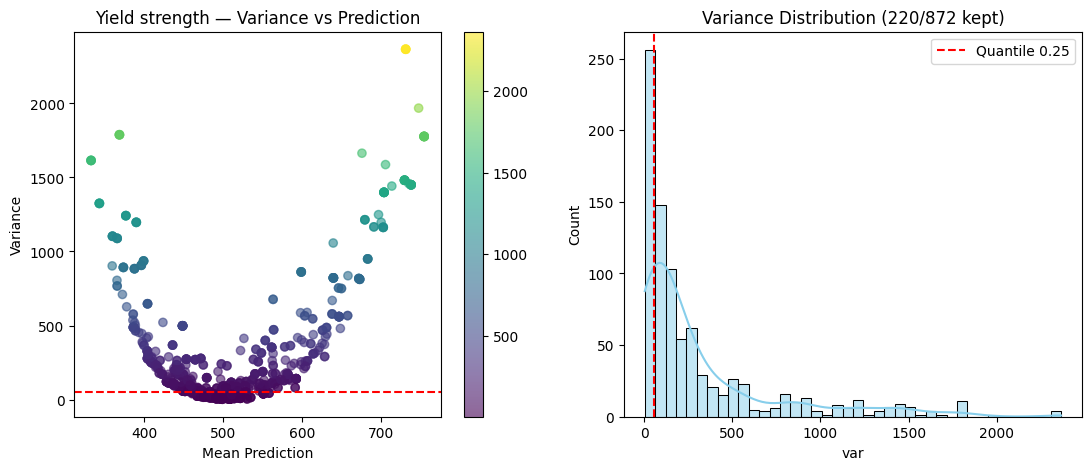

Yield strength: 220/872 pseudo-labels kept (quantile=0.25).

=== Ultimate tensile strength ===


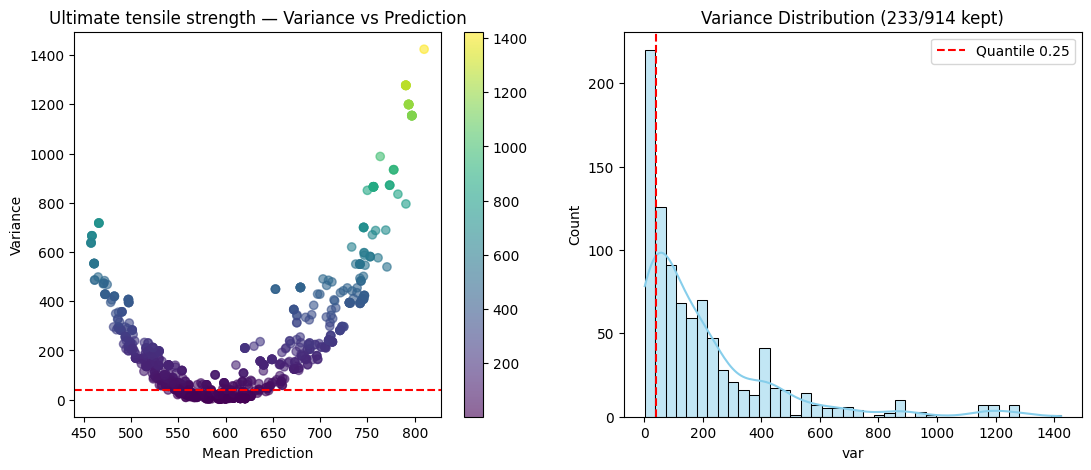

Ultimate tensile strength: 233/914 pseudo-labels kept (quantile=0.25).

=== Elongation ===


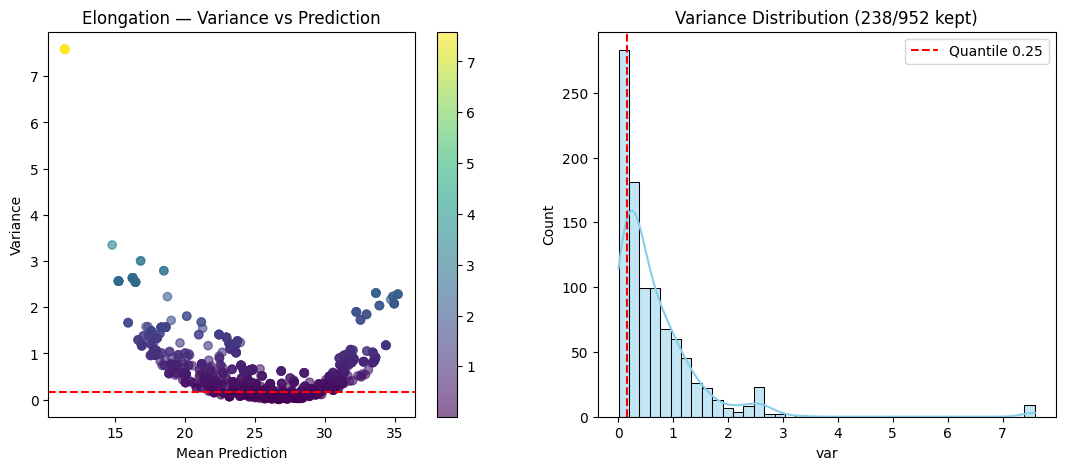

Elongation: 238/952 pseudo-labels kept (quantile=0.25).

=== Reduction of area ===


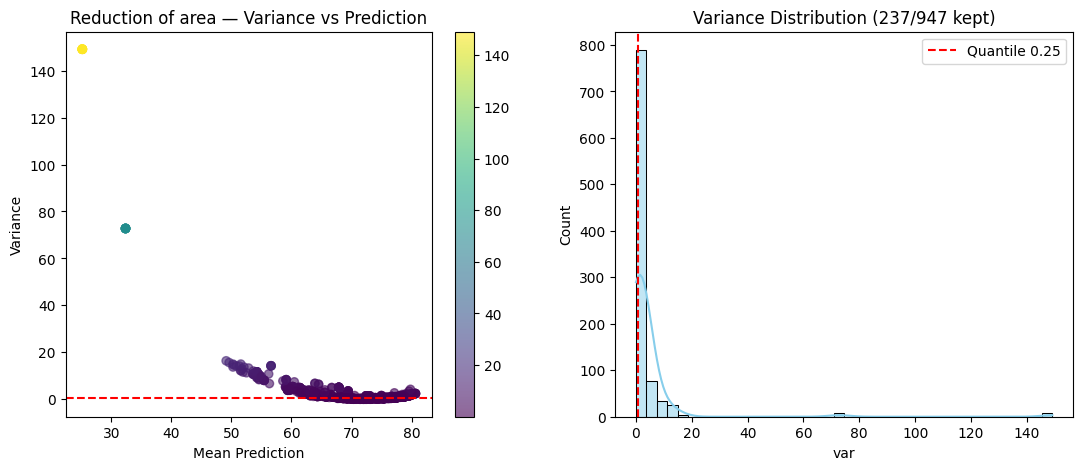

Reduction of area: 237/947 pseudo-labels kept (quantile=0.25).

Performance before semi-supervised learning


,target,RMSE,corr,RMSE/MEAN
0,Yield strength,43.38,0.88,8.53
1,Ultimate tensile strength,35.61,0.92,5.99
2,Elongation,2.83,0.82,10.77
3,Reduction of area,4.90,0.84,6.82



Performance after semi-supervised learning


,target,RMSE,corr,RMSE/MEAN
0,Yield strength,36.90,0.90,7.29
1,Ultimate tensile strength,31.45,0.92,5.30
2,Elongation,2.26,0.86,8.61
3,Reduction of area,4.43,0.83,6.14


In [33]:
results = []
results_post_filling = []

for target_name, cfg in target_configs.items():
    print(f"\n=== {target_name} ===")
    numerical_cols = cfg["numerical_cols"]
    onehot_cols = cfg["onehot_cols"]
    params = cfg["params"]
    regressor = cfg["regressor"]

    # --- Step 1: Evaluate model on original labeled data ---
    rmse, corr, perc = train_regressor_target(
        df=df,
        target_name=target_name,
        numerical_cols=numerical_cols,
        onehot_cols=onehot_cols,
        regressor=regressor,
        params=params,
        n_splits=10,
        plot=False
    )

    results.append({
        "target": target_name,
        "RMSE": rmse,
        "corr": corr,
        "RMSE/MEAN": perc
    })


    # --- Step 2: Semi-supervised learning ---
    # Fill missing target values using XGB predictions with highest confidence (lowest variance)
    df_iter = fill_target_with_xgb_confidence(
        df,
        target_name,
        numerical_cols,
        onehot_cols,
        regressor,
        params,
        random_state=42,
        confidence_quantile=0.25,
        return_model=False
    )

    # --- Step 3: Evaluate model after semi-supervised imputation ---
    rmse_post_filling, corr_post_filling, perc_post_filling = train_regressor_target(
        df=df_iter,
        target_name=target_name,
        numerical_cols=numerical_cols,
        onehot_cols=onehot_cols,
        regressor=regressor,
        params=params,
        n_splits=10,
        plot=False
    )

    results_post_filling.append({
        "target": target_name,
        "RMSE": rmse_post_filling,
        "corr": corr_post_filling,
        "RMSE/MEAN": perc_post_filling
    })

# --- Step 4: Display performance before semi-supervised learning ---
print("\nPerformance before semi-supervised learning")
results_df = pd.DataFrame(results)
display(results_df)

# --- Step 5: Display performance after semi-supervised learning ---
print("\nPerformance after semi-supervised learning")
results_df_post_filling = pd.DataFrame(results_post_filling)
display(results_df_post_filling)

### Observations on Semi-Supervised Learning Results

- **Model performance improved**: We observe gains in RMSE after filling missing target values using the semi-supervised XGBoost approach.  
- **Bias towards mean-centered values**: The algorithm tends to add predicted values concentrated around the mean, because it is most confident where original data is abundant (typically near the mean). This introduces a bias and gives more weight to central values.  
- **Positive outcome**: Despite the bias, the improvement in RMSE and R² suggests that the algorithm received useful additional information, enhancing its predictive power.  
- **Next steps**: 
  - We can now update our dataset with these improved predictions.  
  - Optionally, we can iterate the semi-supervised procedure again to try to recover even more reliable data.  

### Rebuilding the Original DataFrame with Filled Targets

We restore the original dataset structure (`df_origin`) while keeping the **targets filled** during the semi-supervised step.  
Each target column from `df_iter` replaces its counterpart in `df_origin`, preserving original features but completing missing values.  
The resulting `df_filled` is ready for final training or analysis.


In [34]:
# --- Rebuild df with original features but filled targets ---

df_filled = df_origin.copy()

# Copy only the target columns that exist in df_iter (those filled by semi-supervised step)
target_cols_iter = [col for col in df_iter.columns if col in target_configs.keys()]

print("Copying filled target columns from df_iter to df_filled:")
for t in target_cols_iter:
    n_missing_before = df_filled[t].isna().sum()
    df_filled[t] = df_iter[t]
    n_missing_after = df_filled[t].isna().sum()
    print(f"  - {t}: {n_missing_before} → {n_missing_after} missing values after update")

print("\ndf_filled is now the original dataset with filled target columns.")


Copying filled target columns from df_iter to df_filled:
  - Yield strength: 872 → 652 missing values after update
  - Ultimate tensile strength: 914 → 681 missing values after update
  - Elongation: 952 → 714 missing values after update
  - Reduction of area: 947 → 710 missing values after update

df_filled is now the original dataset with filled target columns.


### Semi-Supervised Filling of Missing Targets

We now apply the `fill_missing_targets()` function to fill all missing target values.  
This will:

- Train a model for each target on the available observed data.
- Predict the missing values using the trained model.
- Display distribution and boxplot comparisons between observed and predicted values.
- Return the completed dataset and the indices of samples that were predicted for each target.



=== Final Training and Prediction Phase ===

───────────────────────────────────────────────
Target: Yield strength
───────────────────────────────────────────────
Training samples: 1000
Missing samples to predict: 652
Filled 652 missing values for Yield strength.


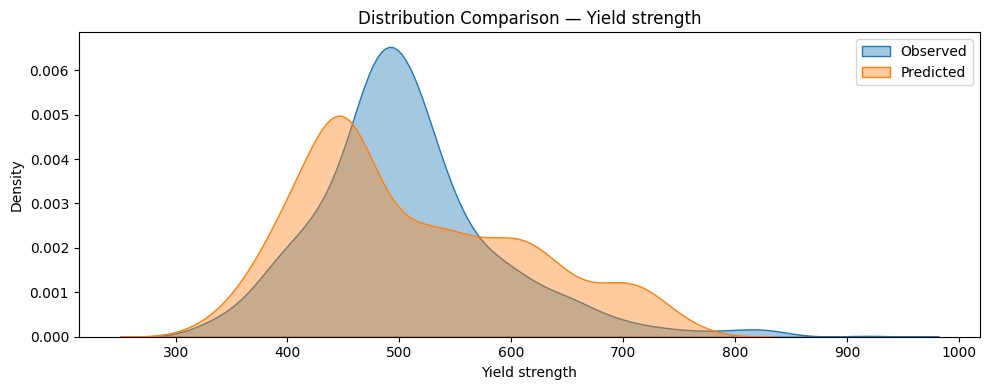

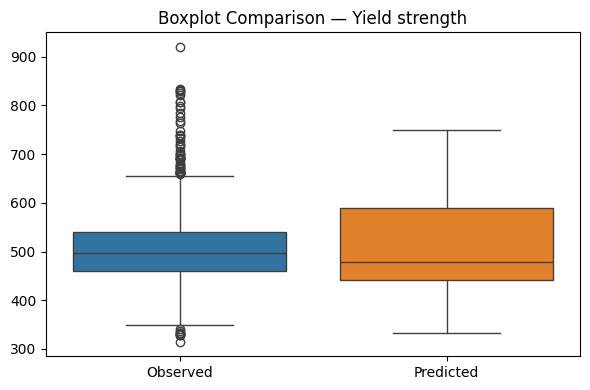


───────────────────────────────────────────────
Target: Ultimate tensile strength
───────────────────────────────────────────────
Training samples: 971
Missing samples to predict: 681
Filled 681 missing values for Ultimate tensile strength.


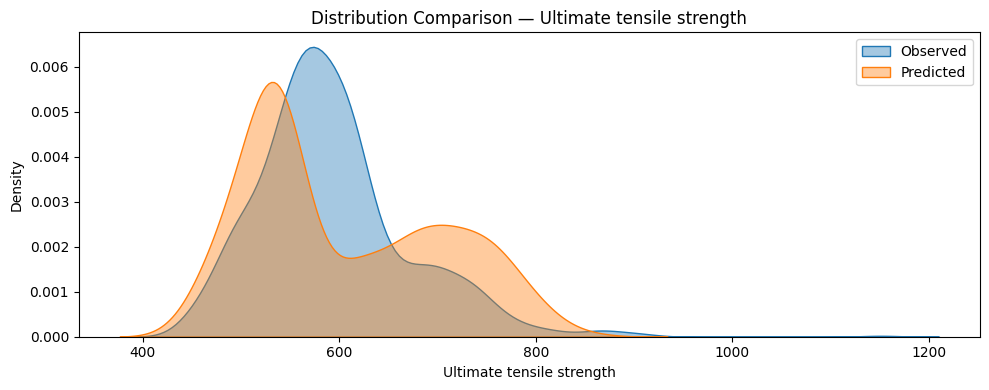

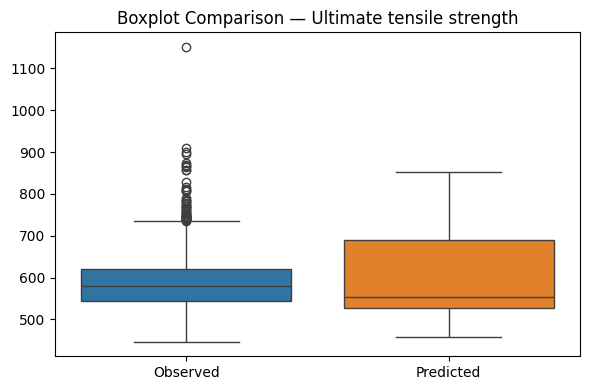


───────────────────────────────────────────────
Target: Elongation
───────────────────────────────────────────────
Training samples: 938
Missing samples to predict: 714
Filled 714 missing values for Elongation.


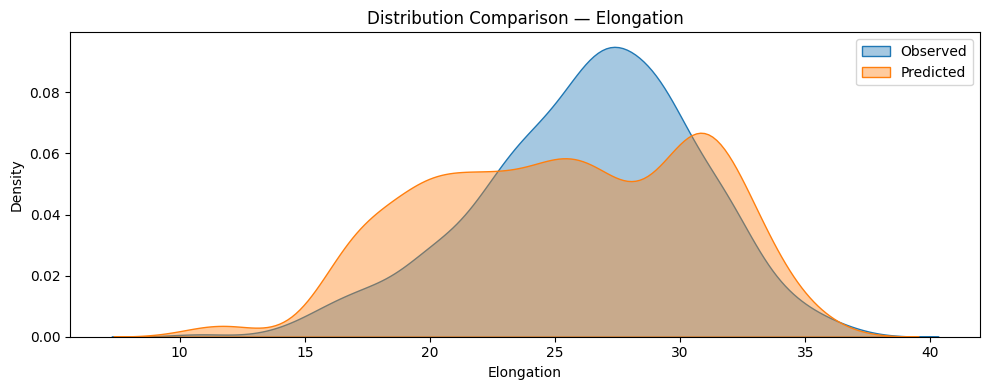

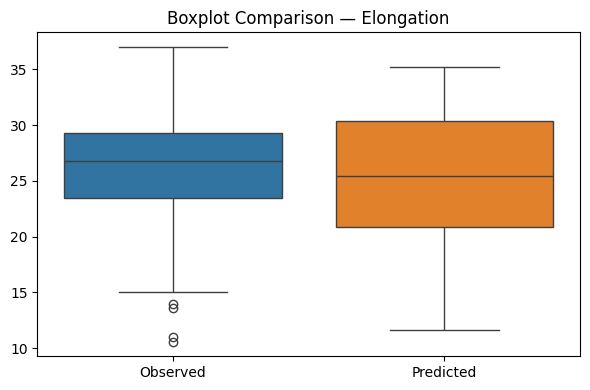


───────────────────────────────────────────────
Target: Reduction of area
───────────────────────────────────────────────
Training samples: 942
Missing samples to predict: 710
Filled 710 missing values for Reduction of area.


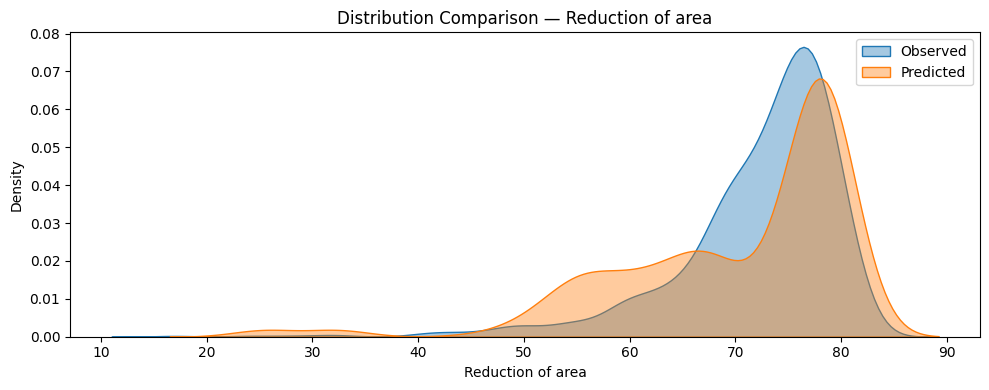

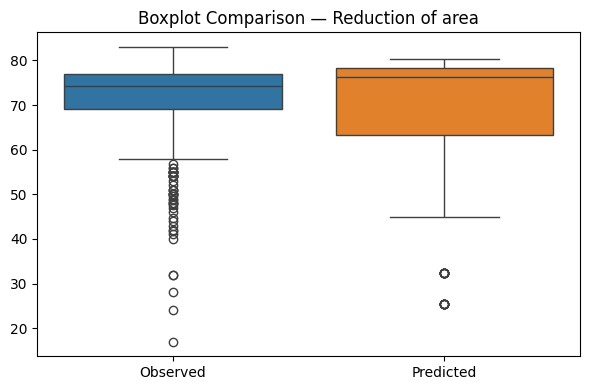



=== Summary of Filled Targets ===


,target,n_filled,n_train,train_mean,pred_mean,train_std,pred_std
0,Yield strength,652,1000,506.31,511.40,82.82,100.36
1,Ultimate tensile strength,681,971,593.03,604.12,78.16,99.29
2,Elongation,714,938,26.31,25.34,4.36,5.33
3,Reduction of area,710,942,72.15,70.06,7.87,11.09


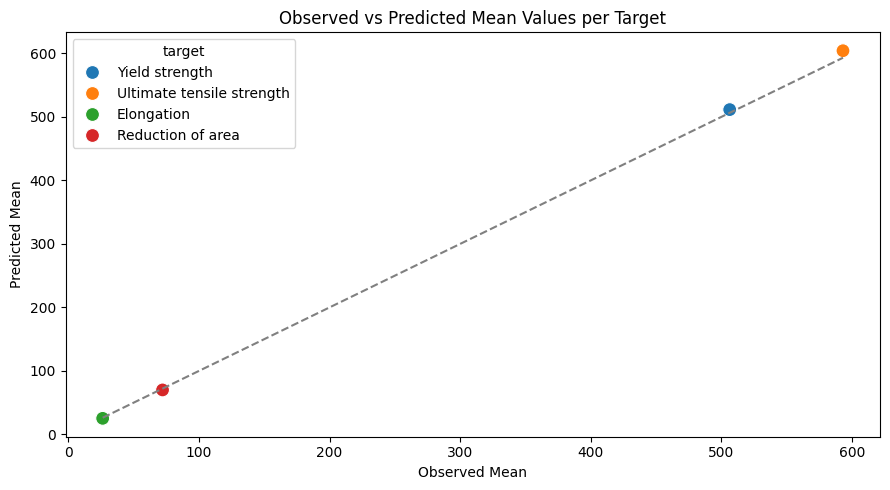


 Predicted indices by target:
 - Yield strength: 652 predicted samples
 - Ultimate tensile strength: 681 predicted samples
 - Elongation: 714 predicted samples
 - Reduction of area: 710 predicted samples


In [35]:
df_final, predicted_indices, summary = fill_missing_targets(
    df_filled=df_filled,
    target_configs=target_configs,
    impute_missing_values=impute_missing_values
)

print("\n Predicted indices by target:")
for t, idxs in predicted_indices.items():
    print(f" - {t}: {len(idxs)} predicted samples")



### Categorize the predicted samples as good welding or not

The quality of a weld does not only depends on its mechanical properties but mostly on the the mechanical properties of the piece of metal to be welded. According to Tracey Cool's thesis, we will consider a weld to be good if its mechanical properties are "as good as" the weakest metal

We will only consider the **Yield Strength**, the **Ultimate tensile Strength**, the **Elongation** and the **Reduction of area** (as a replacement for the Thougness). We want to maximise the **Yield Strength**, the **Ultimate tensile Strength**, the **Elongation**. However, we would like to minimize the Thougness, so we will try to minimize the **Reduction of area**.

In [36]:
import importlib
import postprocessing
importlib.reload(postprocessing)
classif_weld = postprocessing.classif_weld


We gathered the following data from the following sources :  
NF616 : https://www.phase-trans.msm.cam.ac.uk/2012/Cool_Thesis.pdf  
P91 : https://www.mdpi.com/1996-1944/17/17/4398  
P92 : https://www.degruyterbrill.com/document/doi/10.1515/htmp-2020-0087/html?lang=en  
12Cr1MoV : https://www.steel-plate-china.com/news/1000010000001006.html  

In [37]:
bdd_metal = {
    'NF616' : {"Yield strength" : 525,
                "Ultimate tensile strength" : 680,
                "Elongation" : 22,
                "Reduction of area" : 72},
    "P91" : {"Yield strength" : 545,
                "Ultimate tensile strength" : 680,
                "Elongation" : 22,
                "Reduction of area" : 73},
    "P92" : {"Yield strength" : 525,
                "Ultimate tensile strength" : 700,
                "Elongation" : 28,
                "Reduction of area" : 70},
    "12Cr1MoV" : {"Yield strength" : 245,
                "Ultimate tensile strength" : 490,
                "Elongation" : 22,
                "Reduction of area" : 50},
}

Now, we can classify the dataset to search for acceptable welds :

NF616 + NF616
Acceptable welds for NF616 + NF616 : 86
Number of acceptable weld from the original/filled dataset : 30
Number of acceptable weld which has at least one predicted target : 56


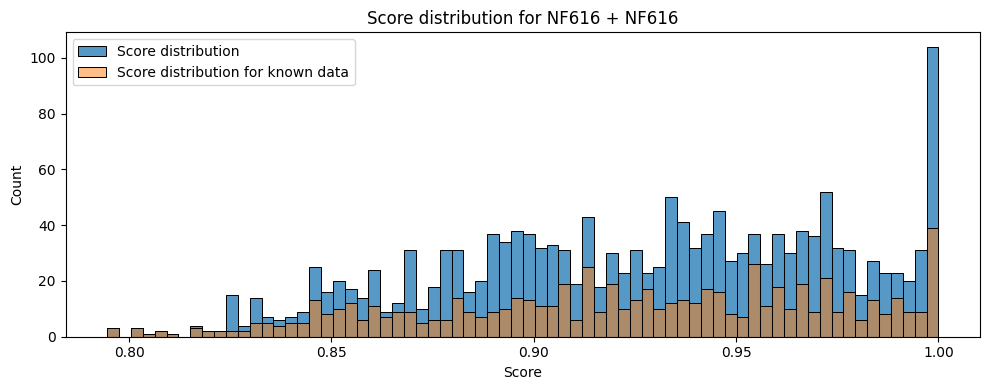

NF616 + P91
Acceptable welds for NF616 + P91 : 89
Number of acceptable weld from the original/filled dataset : 32
Number of acceptable weld which has at least one predicted target : 57


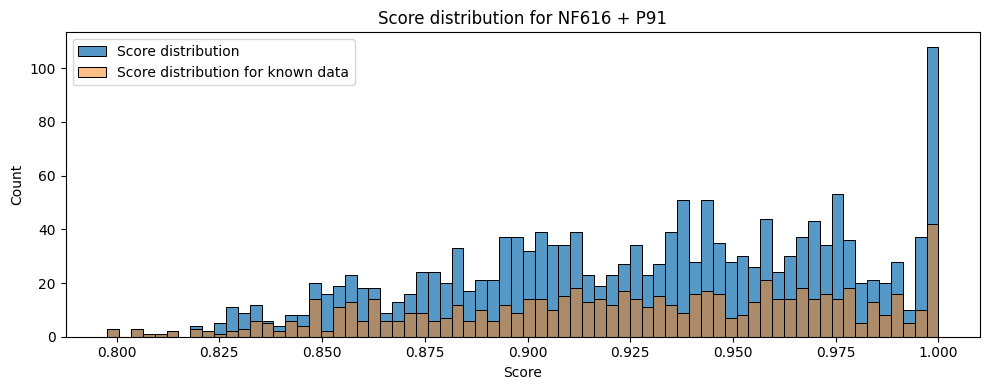

NF616 + P92
Acceptable welds for NF616 + P92 : 86
Number of acceptable weld from the original/filled dataset : 30
Number of acceptable weld which has at least one predicted target : 56


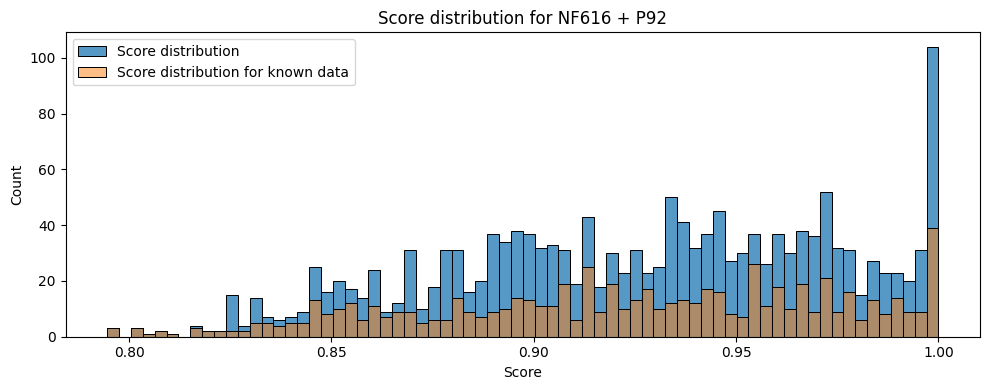

NF616 + 12Cr1MoV
Acceptable welds for NF616 + 12Cr1MoV : 354
Number of acceptable weld from the original/filled dataset : 131
Number of acceptable weld which has at least one predicted target : 223


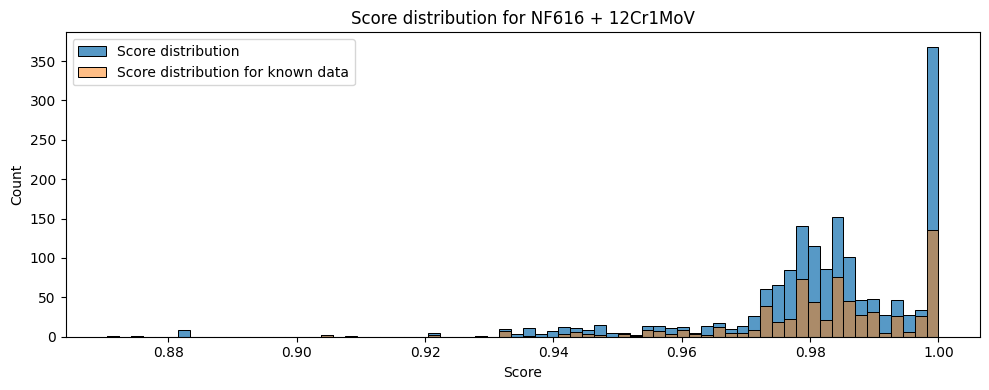

P91 + P91
Acceptable welds for P91 + P91 : 86
Number of acceptable weld from the original/filled dataset : 31
Number of acceptable weld which has at least one predicted target : 55


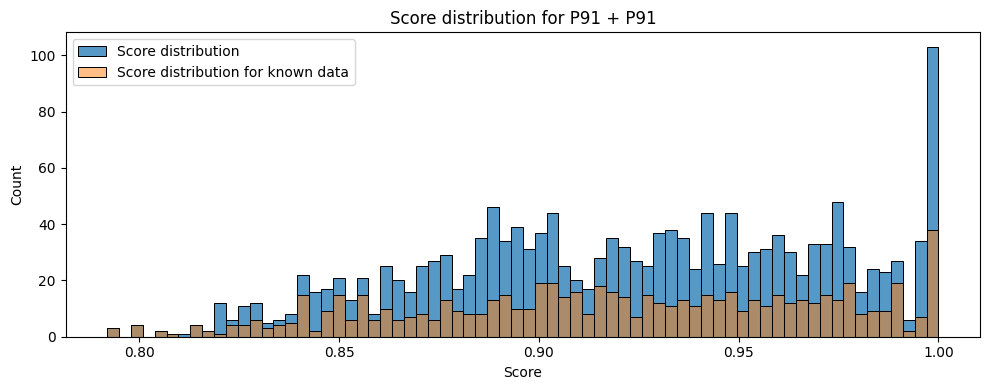

P91 + P92
Acceptable welds for P91 + P92 : 89
Number of acceptable weld from the original/filled dataset : 32
Number of acceptable weld which has at least one predicted target : 57


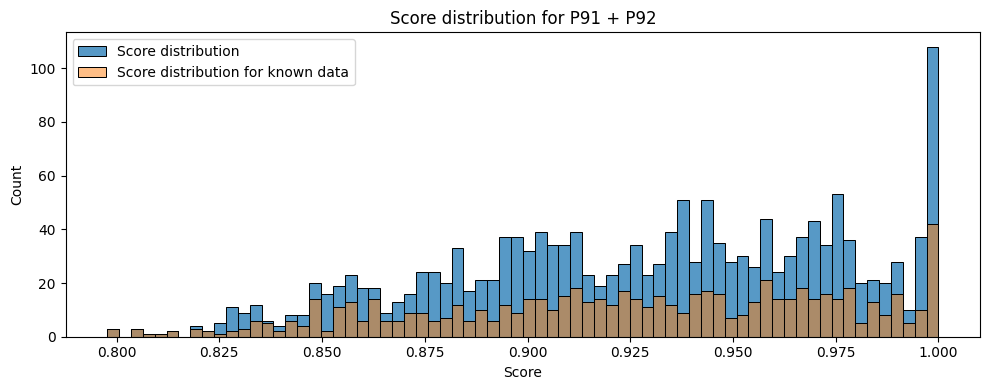

P91 + 12Cr1MoV
Acceptable welds for P91 + 12Cr1MoV : 391
Number of acceptable weld from the original/filled dataset : 158
Number of acceptable weld which has at least one predicted target : 233


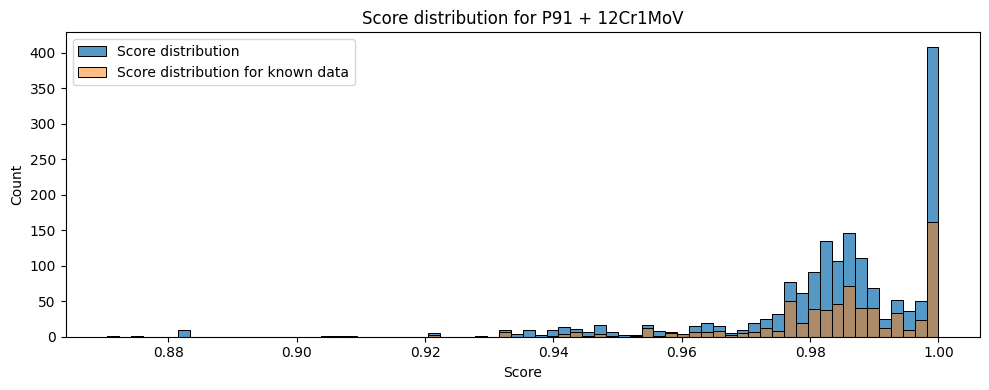

P92 + P92
Acceptable welds for P92 + P92 : 4
Number of acceptable weld from the original/filled dataset : 1
Number of acceptable weld which has at least one predicted target : 3


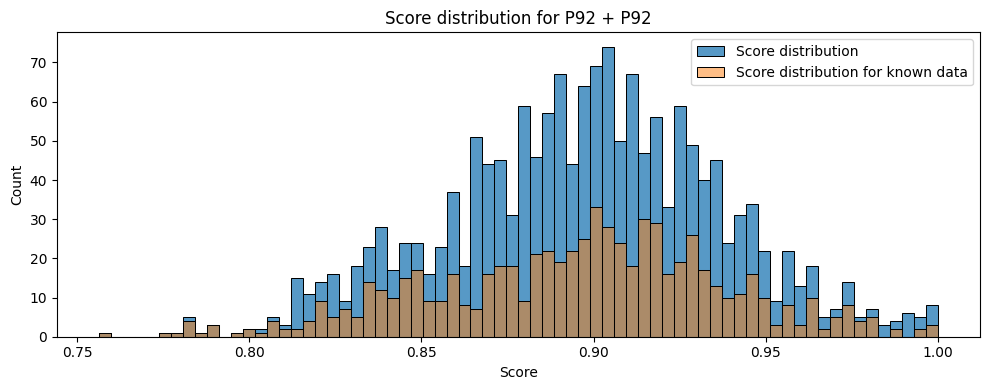

P92 + 12Cr1MoV
Acceptable welds for P92 + 12Cr1MoV : 303
Number of acceptable weld from the original/filled dataset : 105
Number of acceptable weld which has at least one predicted target : 198


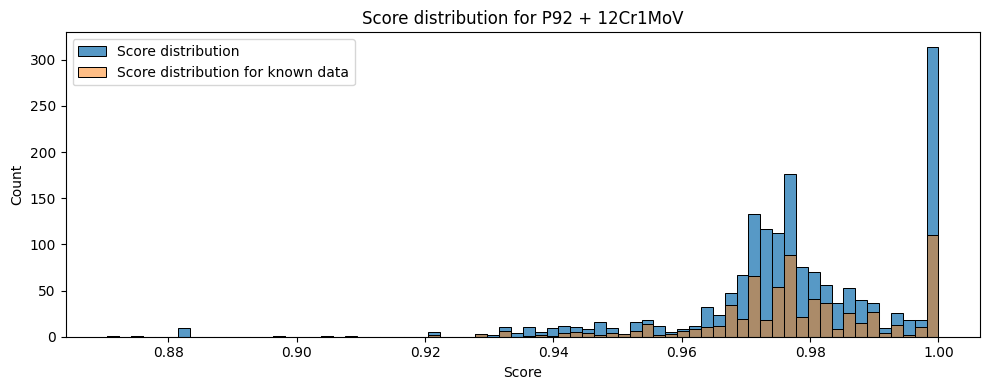

12Cr1MoV + 12Cr1MoV
Acceptable welds for 12Cr1MoV + 12Cr1MoV : 15
Number of acceptable weld from the original/filled dataset : 8
Number of acceptable weld which has at least one predicted target : 7


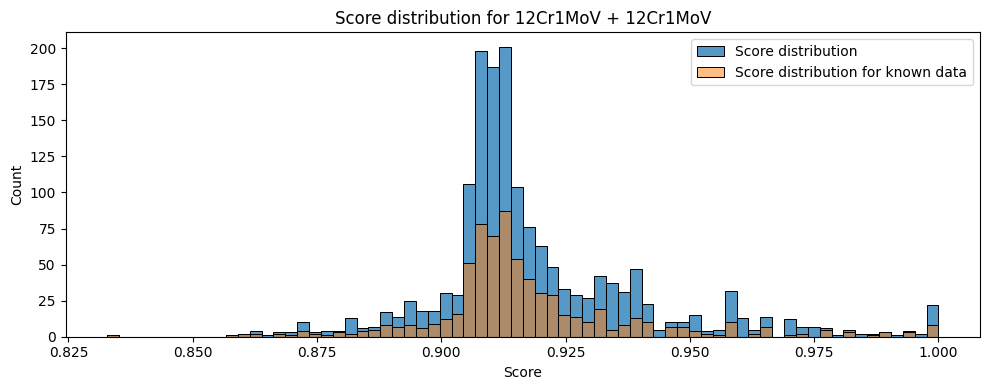

In [38]:
df_classif_score = classif_weld(bdd_metal, df_final, "score")
df_classif_bin = classif_weld(bdd_metal, df_final, "binary")
df_classif_detail = classif_weld(bdd_metal, df_final, "detail")


plot_result(predicted_indices, df_classif_bin, df_classif_score)


We can notice that for ***P92 + P92*** and ***"12Cr1MoV + 12Cr1MoV"***, there only few weld that satisfy the mechanical conditions. We can look at the details to see which mechanical conditions failed :

In [39]:
hard_weld = ["P92 + P92", "12Cr1MoV + 12Cr1MoV"]

count_fail_cause(hard_weld, df_classif_detail)

P92 + P92
Number of unnacceptable weld due to Yield Strength : 1080
Number of unnacceptable weld due to Ultimate Tensile Strength : 1387
Number of unnacceptable weld due to Elongation : 1040
Number of unnacceptable weld due to Reduction of Area : 1082
--------------------------------------------------------------------
12Cr1MoV + 12Cr1MoV
Number of unnacceptable weld due to Yield Strength : 0
Number of unnacceptable weld due to Ultimate Tensile Strength : 105
Number of unnacceptable weld due to Elongation : 346
Number of unnacceptable weld due to Reduction of Area : 1602
--------------------------------------------------------------------


12Cr1MoV is a very ductile steel and its *Yield strength* and *Ultimate tensile strength* are therefore not very restrictive. Its *Elongation* is a bit more restrictive but it is really its *Reduction of area* that limits the number of suitable weld. This can also be seen with the value count of df_classif_detail["12Cr1MoV + 12Cr1MoV"].

In [40]:
print(df_classif_detail["12Cr1MoV + 12Cr1MoV"].value_counts())

12Cr1MoV + 12Cr1MoV
(Reduction of area,)                              1186
(Elongation, Reduction of area)                    311
(Ultimate tensile strength, Reduction of area)     105
(Elongation,)                                       35
Good                                                15
Name: count, dtype: int64


There are very few suitable welds that verify all the mechanical constraints of P92 + P92 at the same time. Having a high elongation (28%) while keeping high Yield Strength and Ultimate tensile strength is rarely achievable. This is also noticeable within the value count :

In [41]:
print(df_classif_detail["P92 + P92"].value_counts())

P92 + P92
(Yield strength, Ultimate tensile strength, Reduction of area)                538
(Yield strength, Ultimate tensile strength, Elongation, Reduction of area)    333
(Elongation,)                                                                 231
(Ultimate tensile strength, Elongation, Reduction of area)                    188
(Yield strength, Ultimate tensile strength, Elongation)                       154
(Ultimate tensile strength, Elongation)                                       109
(Yield strength, Ultimate tensile strength)                                    45
(Elongation, Reduction of area)                                                19
(Ultimate tensile strength,)                                                   17
(Yield strength, Elongation)                                                    6
Good                                                                            4
(Yield strength,)                                                               4
(Ultim

# CONCLUSION

Using a semi-supervised machine learning method, we were able to build a model that can predict the **Yield strength**, the **Ultimate tensile strength**, the **Elongation** and the **Reduction of area** (that is strongly correlated to the **Thoughness**) of a proposed weld, based on its characteristics.

Using these **predictions**, we can judge the quality of a weld by comparing its mechanical properties to the wrought steels *weakest* mechanical properties. If the predicted *mechanical properties of a weld* meet the weakest of those from the wrought steels, the weld is a good candidate for these wrought steel and should be strong enough to weld them.